# ESG점수를 반영한 함수 제작

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

In [2]:
PBR_origin = pd.read_csv('PBR_Kospi.csv', encoding = "ANSI")
PER_origin = pd.read_csv('PER_Kospi.csv', encoding = "ANSI")
# 월간 수익률 데이터 가져오기
profit = pd.read_csv('코스피_월간수익률.csv', encoding = "UTF-8")

# 한국은행 금리 데이터
interest = pd.read_csv('Interest rate.csv', encoding = "UTF-8")

# 종가 데이터 가져오기
closings = pd.read_csv('코스피_종가.csv', encoding = "UTF-8")

In [3]:
esg = pd.read_csv('ESG_data.csv', encoding = "UTF-8")

In [4]:
# 데이터 선별에 이용할 컬럼명 추출
PBR_list = PBR_origin.columns
PER_list = PER_origin.columns

In [5]:
# 필요없는 행 삭제
esg = esg.iloc[6:,:]

# 행열 전환및 컬럼명 재지정
esg = esg.transpose()
esg = esg.rename(columns=esg.iloc[0])
esg = esg.reset_index(drop=True)
esg = esg.iloc[1:,:]

# 불필요한 열 삭제
esg.drop(labels=['Code', 'Item Code', 'Unit', 'Base Date', 'D A T E'],axis=1, inplace = True)

In [6]:
# 필요없는 행 삭제
profit = profit.iloc[6:,:]

# 행열 전환및 컬럼명 재지정
profit = profit.transpose()
profit = profit.rename(columns=profit.iloc[0])
profit = profit.reset_index(drop=True)
profit = profit.iloc[1:,:]

# 불필요한 열 삭제
profit.drop(labels=['Code', 'Item Code', 'Unit', 'Base Date', 'D A T E'],axis=1, inplace = True)

In [7]:
# 불필요한 행 삭제
closings = closings.iloc[6:,:]

# 행열 전환및 컬럼명 재지정
closings = closings.transpose()
closings = closings.rename(columns=closings.iloc[0])
closings = closings.reset_index(drop=True)
closings = closings.iloc[1:,:]

# 필요없는 열 삭제
closings.drop(labels=['Item Code', 'Unit', 'Base Date', 'D A T E'],axis=1, inplace = True)

In [8]:
# 기준금리만 추출
interest = pd.DataFrame(interest.iloc[6,:])
interest = interest.transpose()

In [19]:
index= pd.DataFrame(PBR_origin['기업명'], columns = ['기업명']) 

# 최종 이익 계산을 위한 기업명 데이터 프레임
final_profit= pd.DataFrame(PBR_origin['기업명'], columns = ['기업명']) 

# 그래프 생성을 위한 데이터 프레임
glist = list()

### 수익률 비율 고려

In [20]:
def quant(i):
    global k
    global final_profit
    global hand
    global invest_money_for_hand
    global n
    global glist
    
    check = 0
    spare_money = 0
    
    if i >= 73:
        esg_index = esg[esg.iloc[:, n].apply(int) == 0].index
        print(len(esg_index))
        
        PBR_drop = PBR_origin.drop(esg_index)
        PER_drop = PER_origin.drop(esg_index)
    else:
        PBR_drop = PBR_origin
        PER_drop = PER_origin
    
    
    # PBR 순위매기기
    PBR_drop[PBR_list[i]] = PBR_drop[PBR_list[i]].apply(lambda x : np.nan if x < 0 else x) # 0보다 작은 값 NA처리
    PBR_del_na = PBR_drop.iloc[:, [0, i]].dropna() # NA값 삭제
    rank_PBR = PBR_del_na
    rank_PBR['rank'] = PBR_del_na.iloc[:,1].rank(method='min') #순위 매기기
    
    # PER 순위매기기
    PER_drop[PER_list[i]] = PER_drop[PER_list[i]].apply(lambda x : np.nan if x < 0 else x) # 0보다 작은 값 NA처리
    PER_del_na = PER_drop.iloc[:, [0, i]].dropna() # NA값 삭제
    rank_PER = PER_del_na
    rank_PER['rank'] = PER_del_na.iloc[:,1].rank(method='min') #순위 매기기
    
    # 두 데이터 프레임 합치기
    rank_all = pd.merge(rank_PBR, rank_PER, on = '기업명', how = 'left') # PBR & PER dateframe 합치기
    
    # PBR + PER 값으로 순위 정렬
    rank_all['rank_all'] = rank_all['rank_x'] + rank_all['rank_y']
    rank_all = rank_all.iloc[:,[0,5]].sort_values(by='rank_all' ,ascending=True)

    # 50개 기업 추출
    rank_all = rank_all.iloc[0:50,:]
    
    # 기업명 추출
    profit_year = profit.iloc[:, 0:1].dropna()
    
    if i >= 73:
        profit_year.drop(esg_index, inplace = True)
    profit_year.rename(columns = {'Name' : "기업명"}, inplace =True)
    
    # 일 년 수익률 데이터 프레임 합치기
    profit_year = pd.concat([profit_year,profit.iloc[:, i+1:i+13]],axis=1)
    
    # 모멘텀 계산
    profit_year['momentum'] = ((profit_year.iloc[:,1].apply(lambda x : float(x) - 1).fillna(1))*(profit_year.iloc[:,2].apply(lambda x : float(x) - 1).fillna(1))*
                          (profit_year.iloc[:,3].apply(lambda x : float(x) - 1).fillna(1))*(profit_year.iloc[:,4].apply(lambda x : float(x) - 1).fillna(1))*
                          (profit_year.iloc[:,5].apply(lambda x : float(x) - 1).fillna(1))*(profit_year.iloc[:,6].apply(lambda x : float(x) - 1).fillna(1))*
                          (profit_year.iloc[:,7].apply(lambda x : float(x) - 1).fillna(1))*(profit_year.iloc[:,8].apply(lambda x : float(x) - 1).fillna(1))*
                          (profit_year.iloc[:,9].apply(lambda x : float(x) - 1).fillna(1))*(profit_year.iloc[:,10].apply(lambda x : float(x) - 1).fillna(1))*
                          (profit_year.iloc[:,11].apply(lambda x : float(x) - 1).fillna(1))*(profit_year.iloc[:,12].apply(lambda x : float(x) - 1).fillna(1) - 1))
    
    # 모멘텀만 따로 추출
    momentum = profit_year.iloc[:, [0, 13]]
    
    # PBR 및 PER 순위와 모멘텀 데이터 프레임 합치기
    profit_rank = pd.merge(rank_all, momentum, on = '기업명', how = 'left')
    
    
    # momentum이 기준금리보다 작을 경우 NAN값으로 변환
    profit_rank['momentum'] = profit_rank['momentum'].apply(lambda x : np.nan if float(x) < interest.iloc[0, i] else x)
    profit_rank = profit_rank.dropna()
    
    # 모멘텀 상위 10개 추출
    profit_rank = profit_rank.sort_values(by='momentum' ,ascending=False).iloc[:10, :]

    # 최근 1년간 수익률 비율 확인
    profit_year = pd.merge(profit_year, profit_rank.iloc[:,0], left_on='기업명', right_on='기업명', how='inner')

    # 수익률이 마이너스일 경우 -1 수익률이 플러스일 경우 1 할당
    for j in range(1,13):
        profit_year.iloc[:,j] = profit_year.iloc[:,j].apply(lambda x : -1 if float(x) < 0 else 1)
    
    # 걸러진 기업을 저장할 데이터 프레임 생성
    drop_low_interest = profit_year.iloc[:,0]
    
    # 기업의 열 합계가 1보다 작을 경우 행을 탈락시킨다
    for h in range(len(profit_year.iloc[:,0])):
        if profit_year.iloc[h,1:13].apply(int).sum() <= -1:
            drop_low_interest = pd.merge(drop_low_interest, profit_year.drop(h, axis = 0), left_on='기업명', right_on='기업명', how='inner')
            check = 1
    
    if check == 0:
        drop_low_interest = pd.merge(drop_low_interest, profit_year, left_on='기업명', right_on='기업명', how='inner')
        
    # 해당 년 종가 데이터 가져오기
    closings_year = closings.iloc[:, [1,i+2]]
    
    # 인덱스 열이름 같게 설정
    closings_year.rename(columns = {'Name' : "기업명"}, inplace =True)
    
    # 모멘텀 상위 10개 기업 데이터프레임과 해당년 종가 데이터프레임 merge
    closings_year_10 = pd.merge(drop_low_interest.iloc[:, 0:3], closings_year, on = '기업명', how = 'left')
    
    # 각 항목당 50억씩 투자하여 몇 주씩 샀는지 남은 금액은 얼마인지 저장 (처음만 50억을 기본금으로)  
    if i == 1:
        if len(closings_year_10.iloc[:,0]) == 0:
            hand = 50000000000
        else:
            hand = 50000000000 -  (5000000000 * len(closings_year_10.iloc[:,0]))
            print("처음에 저장된 돈: " + str(hand))
        
        closings_year_10['invest'] = closings_year_10.iloc[:, 3].apply(lambda x: int(5000000000 / int(x.replace(',', ''))))
        closings_year_10['rest_money'] = closings_year_10.iloc[:, 3].apply(lambda x: 5000000000 % int(x.replace(',', '')))
    else:    
        # NA값이 없는 기업명 추출
        #print(final_profit)
        index_list = final_profit.iloc[:,2*k - 1].dropna(axis = 0)
        #print(index_list)
        index_list = index_list.index
        
        # 기존의 주식을 팔고 새 주식을 삼.
        for b in range(len(index_list)):
            #기업의 해당 년 종가 데이터 가져오기
            stock_price = closings_year.loc[(closings_year['기업명'] == final_profit.iloc[int(index_list[b]), 0])]

            # 겹치지 않는 종목 판매 후 투자 원금에 회수
            spare_money += int(final_profit.iloc[int(index_list[b]), 2*k -1]) *int(stock_price.iloc[0,1].replace(',',''))  + int(final_profit.iloc[int(index_list[b]), 2*k])
        
        print("판매 금액: " + str(spare_money))
        
       
        spare_money += hand
        
        print("다음 투자 후 저장된 돈: " + str(spare_money))
        glist.append(spare_money)
        # 돈 10등분
        if len(closings_year_10.iloc[:,0]) == 0:
            invest_money_for_hand = spare_money
            invest_money = 0
        else:
            if len(index_list) == 0:
                invest_money = invest_money_for_hand + spare_money
                
            invest_money = int(spare_money / 10)
            hand = invest_money*(10 - len(closings_year_10.iloc[:,0]))
            print("해단 년도 투자하고 남은 돈 " + str(hand))
        
        closings_year_10['invest'] = closings_year_10.iloc[:, 3].apply(lambda x: int(invest_money / int(x.replace(',', ''))))
        closings_year_10['rest_money'] = closings_year_10.iloc[:, 3].apply(lambda x: invest_money % int(x.replace(',', '')))           
        
    closings_year_10.drop(closings_year_10.columns[1], axis = 1, inplace = True)
    
    # 최종 수익률 계산 위한 데이터 프레임 제작
    profit_whole = index
    profit_whole_update = pd.merge(profit_whole, closings_year_10, on = '기업명', how = 'left')
    
    # invest와 rest 열만 남기기
    profit_whole_update = profit_whole_update.iloc[:, 3:5]
    
    final_profit = pd.concat([final_profit, profit_whole_update], axis = 1)
    

In [21]:
global k
k = 0

global n
n = 2

In [22]:
for j in range(1,122, 3):
    print('=====================start==========='+ str(j) + '=================================')
    quant(j) 
    k += 1
    if j >= 73:
        n += 1
    print('================================'+ str(j) + '=================================')

=====================start===========1=================================
처음에 저장된 돈: 5000000000
================================1=================================
=====================start===========4=================================
판매 금액: 49206990005
다음 투자 후 저장된 돈: 54206990005
해단 년도 투자하고 남은 돈 5420699000
================================4=================================
=====================start===========7=================================
판매 금액: 56276478890
다음 투자 후 저장된 돈: 61697177890
해단 년도 투자하고 남은 돈 12339435578
================================7=================================
=====================start===========10=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\l

판매 금액: 62350845942
다음 투자 후 저장된 돈: 74690281520
해단 년도 투자하고 남은 돈 29876112608
================================10=================================
=====================start===========13=================================
판매 금액: 59980213182
다음 투자 후 저장된 돈: 89856325790
해단 년도 투자하고 남은 돈 0
================================13=================================
=====================start===========16=================================
판매 금액: 89846902505
다음 투자 후 저장된 돈: 89846902505
해단 년도 투자하고 남은 돈 26954070750
================================16=================================
=====================start===========19=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\l

판매 금액: 70209519530
다음 투자 후 저장된 돈: 97163590280
해단 년도 투자하고 남은 돈 9716359028
================================19=================================
=====================start===========22=================================
판매 금액: 79313421232
다음 투자 후 저장된 돈: 89029780260
해단 년도 투자하고 남은 돈 44514890130
================================22=================================
=====================start===========25=================================
판매 금액: 46562277675
다음 투자 후 저장된 돈: 91077167805
해단 년도 투자하고 남은 돈 36430867120
================================25=================================
=====================start===========28=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 59396133130
다음 투자 후 저장된 돈: 95827000250
해단 년도 투자하고 남은 돈 0
================================28=================================
=====================start===========31=================================
판매 금액: 89661415195
다음 투자 후 저장된 돈: 89661415195
해단 년도 투자하고 남은 돈 62762990633
================================31=================================
=====================start===========34=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 32719419897
다음 투자 후 저장된 돈: 95482410530
해단 년도 투자하고 남은 돈 47741205265
================================34=================================
=====================start===========37=================================
판매 금액: 46563025895
다음 투자 후 저장된 돈: 94304231160
해단 년도 투자하고 남은 돈 9430423116
================================37=================================
=====================start===========40=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 101018179069
다음 투자 후 저장된 돈: 110448602185
해단 년도 투자하고 남은 돈 77314021526
================================40=================================
=====================start===========43=================================
판매 금액: 35268738184
다음 투자 후 저장된 돈: 112582759710
해단 년도 투자하고 남은 돈 0
================================43=================================
=====================start===========46=================================
판매 금액: 121831387900
다음 투자 후 저장된 돈: 121831387900
해단 년도 투자하고 남은 돈 24366277580
================================46=================================
=====================start===========49=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 105620604125
다음 투자 후 저장된 돈: 129986881705
해단 년도 투자하고 남은 돈 25997376340
================================49=================================
=====================start===========52=================================
판매 금액: 150329326040
다음 투자 후 저장된 돈: 176326702380
해단 년도 투자하고 남은 돈 52898010714
================================52=================================
=====================start===========55=================================
판매 금액: 144187489016
다음 투자 후 저장된 돈: 197085499730
해단 년도 투자하고 남은 돈 78834199892
================================55=================================
=====================start===========58=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 179058759495
다음 투자 후 저장된 돈: 257892959387
해단 년도 투자하고 남은 돈 103157183752
================================58=================================
=====================start===========61=================================
판매 금액: 143333588261
다음 투자 후 저장된 돈: 246490772013
해단 년도 투자하고 남은 돈 98596308804
================================61=================================
=====================start===========64=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 225506907046
다음 투자 후 저장된 돈: 324103215850
해단 년도 투자하고 남은 돈 129641286340
================================64=================================
=====================start===========67=================================
판매 금액: 177242351155
다음 투자 후 저장된 돈: 306883637495
해단 년도 투자하고 남은 돈 122753454996
================================67=================================
=====================start===========70=================================
판매 금액: 181473221004
다음 투자 후 저장된 돈: 304226676000
해단 년도 투자하고 남은 돈 121690670400
================================70=================================
=====================start===========73=================================
681
판매 금액: 173348430990
다음 투자 후 저장된 돈: 295039101390
해단 년도 투자하고 남은 돈 206527370973
================================73=================================
=====================start===========76=================================
684
판매 금액: 104115981087
다음 투자 후 저장된 돈: 310643352060
해단 년도 투자하고 남은 돈 279579016854
================================76=========

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 28561670406
다음 투자 후 저장된 돈: 308140687260
해단 년도 투자하고 남은 돈 246512549808
================================79=================================
=====================start===========82=================================
677
판매 금액: 70445726962
다음 투자 후 저장된 돈: 316958276770
해단 년도 투자하고 남은 돈 190174966062
================================82=================================
=====================start===========85=================================
677
판매 금액: 140428271028
다음 투자 후 저장된 돈: 330603237090
해단 년도 투자하고 남은 돈 198361942254
================================85=================================
=====================start===========88=================================
678


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 145956267236
다음 투자 후 저장된 돈: 344318209490
해단 년도 투자하고 남은 돈 241022746643
================================88=================================
=====================start===========91=================================
679
판매 금액: 124136307847
다음 투자 후 저장된 돈: 365159054490
해단 년도 투자하고 남은 돈 219095432694
================================91=================================
=====================start===========94=================================
674
판매 금액: 134352776196
다음 투자 후 저장된 돈: 353448208890
해단 년도 투자하고 남은 돈 176724104445
================================94=================================
=====================start===========97=================================
674


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 181522204045
다음 투자 후 저장된 돈: 358246308490
해단 년도 투자하고 남은 돈 179123154245
================================97=================================
=====================start===========100=================================
678
판매 금액: 183361719245
다음 투자 후 저장된 돈: 362484873490
해단 년도 투자하고 남은 돈 181242436745
================================100=================================
=====================start===========103=================================
678
판매 금액: 171227559795
다음 투자 후 저장된 돈: 352469996540
해단 년도 투자하고 남은 돈 176234998270
================================103=================================
=====================start===========106=================================
678


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 177886948720
다음 투자 후 저장된 돈: 354121946990
해단 년도 투자하고 남은 돈 283297557592
================================106=================================
=====================start===========109=================================
674
판매 금액: 55585584298
다음 투자 후 저장된 돈: 338883141890
해단 년도 투자하고 남은 돈 203329885134
================================109=================================
=====================start===========112=================================
674


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


판매 금액: 135089292806
다음 투자 후 저장된 돈: 338419177940
================================112=================================
=====================start===========115=================================
674
판매 금액: 0
다음 투자 후 저장된 돈: 203329885134
해단 년도 투자하고 남은 돈 182996896617
================================115=================================
=====================start===========118=================================
674
판매 금액: 19157013433
다음 투자 후 저장된 돈: 202153910050
해단 년도 투자하고 남은 돈 101076955025
================================118=================================
=====================start===========121=================================
672
판매 금액: 95139794915
다음 투자 후 저장된 돈: 196216749940
해단 년도 투자하고 남은 돈 117730049964
================================121=================================


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
# 파일 저장
final_profit.to_csv("please.csv", encoding = "UTF-8")

# 그래프 그리기

### 라이브러리 불러오기

In [23]:
import matplotlib.pyplot as plt

### 그래프 생성을 위한 데이터 프레임 제작

In [24]:
glist = pd.DataFrame(glist)

### 그래프 생성

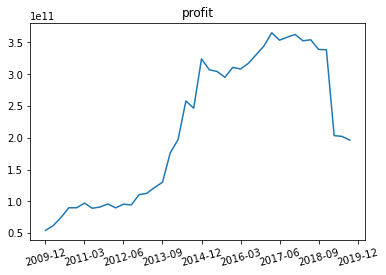

In [25]:
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], ['2009-12','2011-03','2012-06','2013-09','2014-12','2016-03','2017-06',
                                                '2018-09','2019-12'], rotation = 15)
plt.title("profit")
plt.plot(glist)